In [1]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data

In [2]:
# generate data for grid network (features and costs)
m = 20 # number of nodes
n = 1000 # number of data
p = 10 # size of feature
deg = 4 # polynomial degree
x, c = spo.data.tsp.genData(n+1000, p, m, deg=deg, noise_width=0)

## Optimization model

In [3]:
tsp_model = spo.model.tspModel(m)

Academic license - for non-commercial use only - expires 2021-08-20
Using license file C:\Users\Apocrypse\gurobi.lic


In [4]:
# solve
tsp_model.setObj(c[0])
sol, obj = tsp_model.solve()
print('Obj: {}'.format(obj))
tour = tsp_model.getTour(sol)
print(' -> '.join(map(str, tour)))

Obj: 2450.6067
0 -> 8 -> 7 -> 10 -> 12 -> 6 -> 17 -> 15 -> 9 -> 11 -> 16 -> 4 -> 18 -> 3 -> 2 -> 5 -> 1 -> 19 -> 13 -> 14 -> 0


## Data Loader

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [7]:
# get training data set
tsp_dataset_train = spo.data.dataset.optDataset(tsp_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.77it/s]


In [8]:
# get test data set
tsp_dataset_test = spo.data.dataset.optDataset(tsp_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.97it/s]


In [9]:
# get data loader
batch_size = 32
tsp_loader_train = DataLoader(tsp_dataset_train, batch_size=batch_size, shuffle=True)
tsp_loader_test = DataLoader(tsp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(tsp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 10])

In [12]:
c.shape

torch.Size([32, 190])

In [13]:
w.shape

torch.Size([32, 190])

In [14]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [17]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, tsp_model)

In [18]:
# training
twostage_model.fit(tsp_dataset_train.x, tsp_dataset_train.c)

In [19]:
# prediction
c_test_pred = twostage_model.predict(tsp_dataset_test.x)

In [20]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = tsp_dataset_test.c[i]
    z_true_i = tsp_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(tsp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(tsp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(tsp_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(tsp_dataset_test.z.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.20it/s]


Normalized true SPO Loss: 0.18%
Normalized unambiguous SPO Loss: 0.18%


In [21]:
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 64.58, 43.80, 56.23, 68.05, 63.59, 70.66, 78.34, 87.66, 71.33, 78.81, 69.34, 98.80, 103.01, 88.38, 93.05, 70.05, 68.57, 60.57, 112.56, 49.56, 93.84, 45.64, 86.01, 96.63, 68.73, 78.94, 52.56, 58.29, 76.86, 60.36, 64.85, 60.39, 70.12, 54.87, 79.47, 46.14, 75.44, 62.77, 42.57, 62.05, 71.48, 32.80, 56.32, 49.52, 63.92, 41.94, 93.94, 58.01, 47.65, 41.98, 71.27, 46.17, 53.79, 27.16, 59.72, 47.90, 93.93, 84.25, 72.76, 95.92, 84.91, 27.39, 53.80, 86.43, 69.59, 92.87, 80.35, 89.36, 49.40, 43.23, 49.01, 106.59, 91.37, 112.22, 91.86, 55.54, 75.41, 90.59, 99.06, 82.02, 67.05, 66.67, 57.13, 74.15, 48.10, 88.90, 36.29, 77.75, 72.82, 92.10, 85.18, 86.91, 92.55, 71.40, 67.59, 50.63, 75.39, 66.10, 40.41, 53.69, 71.22, 90.86, 102.14, 68.01, 63.23, 120.88, 85.01, 113.17, 95.15, 100.89, 96.19, 89.86, 80.44, 86.61, 81.03, 78.85, 48.78, 61.71, 64.70, 105.59, 77.20, 61.52, 41.01, 80.89, 75.47, 86.02, 95.46, 115.44, 132.35, 56.74, 80.49, 74.44, 71.01, 105.89, 89.60, 61.39, 48.80, 79.1

## Linear Regression from PyTorch 

In [22]:
from torch import nn

In [23]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m*(m-1)//2)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [24]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [25]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [26]:
# init SPO+ loss
criterion = spo.func.SPOPlus()

In [27]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(tsp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(tsp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, tsp_model, tsp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, tsp_model, tsp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:9.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 1870.8921, True SPO Loss:  3.4695%, Unambiguous SPO Loss:  3.4695%
Epoch  20, Loss: 1642.5483, True SPO Loss:  2.1846%, Unambiguous SPO Loss:  2.1846%
Epoch  30, Loss: 1413.3115, True SPO Loss:  1.6668%, Unambiguous SPO Loss:  1.6668%
Epoch  40, Loss: 1369.3452, True SPO Loss:  1.3595%, Unambiguous SPO Loss:  1.3595%
Epoch  50, Loss: 1016.4210, True SPO Loss:  1.1138%, Unambiguous SPO Loss:  1.1138%
Epoch  60, Loss:  761.8241, True SPO Loss:  0.9205%, Unambiguous SPO Loss:  0.9205%
Epoch  70, Loss:  701.7396, True SPO Loss:  0.7456%, Unambiguous SPO Loss:  0.7456%
Epoch  80, Loss:  228.4202, True SPO Loss:  0.6112%, Unambiguous SPO Loss:  0.6112%
Epoch  90, Loss:  497.3358, True SPO Loss:  0.5049%, Unambiguous SPO Loss:  0.5049%
Epoch 100, Loss:  218.2987, True SPO Loss:  0.4200%, Unambiguous SPO Loss:  0.4203%
Epoch 110, Loss:  369.0318, True SPO Loss:  0.3676%, Unambiguous SPO Loss:  0.3676%
Epoch 120, Loss:  546.3859, True SPO Loss:  0.3132%, Unambiguous SPO Loss:  

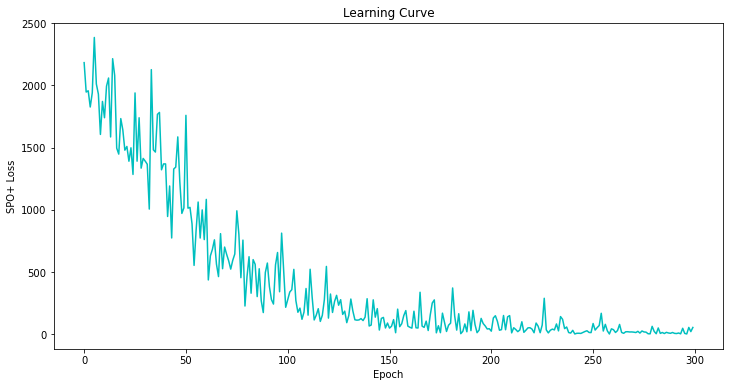

In [28]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

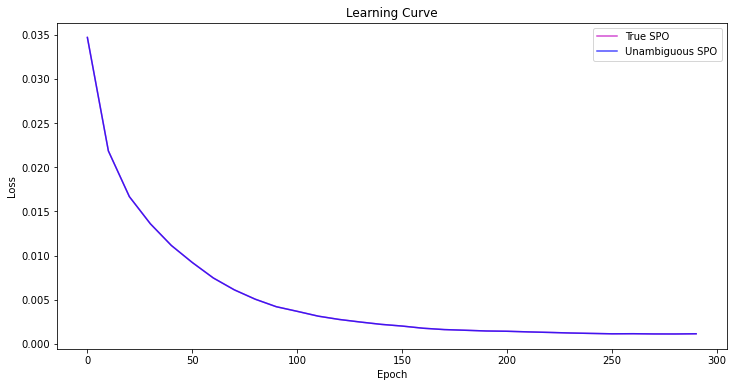

In [29]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [30]:
# evaluate
spoloss = spo.eval.trueSPO(reg, tsp_model, tsp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, tsp_model, tsp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.11%
Normalized unambiguous SPO Loss: 0.11%


In [31]:
reg.eval()
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 64.58, 43.80, 56.23, 68.05, 63.59, 70.66, 78.34, 87.66, 71.33, 78.81, 69.34, 98.80, 103.01, 88.38, 93.05, 70.05, 68.57, 60.57, 112.56, 49.56, 93.84, 45.64, 86.01, 96.63, 68.73, 78.94, 52.56, 58.29, 76.86, 60.36, 64.85, 60.39, 70.12, 54.87, 79.47, 46.14, 75.44, 62.77, 42.57, 62.05, 71.48, 32.80, 56.32, 49.52, 63.92, 41.94, 93.94, 58.01, 47.65, 41.98, 71.27, 46.17, 53.79, 27.16, 59.72, 47.90, 93.93, 84.25, 72.76, 95.92, 84.91, 27.39, 53.80, 86.43, 69.59, 92.87, 80.35, 89.36, 49.40, 43.23, 49.01, 106.59, 91.37, 112.22, 91.86, 55.54, 75.41, 90.59, 99.06, 82.02, 67.05, 66.67, 57.13, 74.15, 48.10, 88.90, 36.29, 77.75, 72.82, 92.10, 85.18, 86.91, 92.55, 71.40, 67.59, 50.63, 75.39, 66.10, 40.41, 53.69, 71.22, 90.86, 102.14, 68.01, 63.23, 120.88, 85.01, 113.17, 95.15, 100.89, 96.19, 89.86, 80.44, 86.61, 81.03, 78.85, 48.78, 61.71, 64.70, 105.59, 77.20, 61.52, 41.01, 80.89, 75.47, 86.02, 95.46, 115.44, 132.35, 56.74, 80.49, 74.44, 71.01, 105.89, 89.60, 61.39, 48.80, 79.1

    True sol: 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 3710.25
    Pred sol: 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 

    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 3906.10
    Pred sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 